# Motion analysis

SarcAsM is structured into the base class `SarcAsM` and the classes `Structure` for structural analysis of images and movies, and `Motion` for tracking and analysis of individual and average sarcomere motion. 

This is a detailed tutorial for automated identification of ROI lines, and sarcomere motion tracking and analysis using our Python package. A detailed documentation of all function of the package can be found [here](../_autosummary/sarcasm.html). 

Below the analysis of a high-speed confocal movie (20s, 65 frames/second) is described. 

## Automated detection of ROI lines for motion tracking
For automated ROI detection, SarcAsM first detects Z-bands using deep learning and analyzes the sarcomere structure and then, on this basis, identifies regions with well-ordered sarcomeres. Function parameters are described [here](../_autosummary/sarcasm.core.SarcAsM.html).

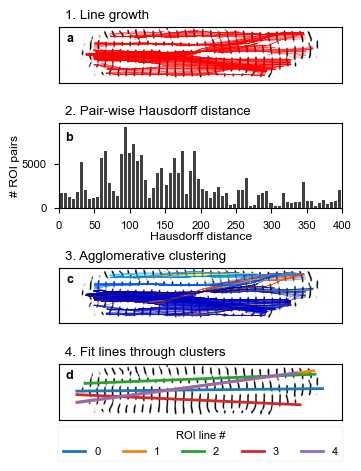

In [9]:
# import package
from sarcasm import *

# enter path of tif-file, can be both single image and movie
filepath = '../../data_acute_drug_treatment/control/2022_10_22_20kPa_Diff427_Day23_Control_Well3a_lif_Series047.tif'

# initialize SarcAsM object
sarc_obj = SarcAsM(filepath)

Creating metadata...


In [10]:
# prediction of Z-bands using deep learning (using Siam-U-Net for better temporal consistency)
sarc_obj.predict_z_bands(siam_unet=True, size=(256, 1024))

# analysis of sarcomere length and orientation (only single timepoint)
sarc_obj.analyze_sarcomere_length_orient(timepoints=0)

Predicting sarcomere z-bands ...
Predicting data ...



  0%|          | 0/1334 [00:00<?, ?it/s]

Patches shape:(1, 2, 256, 1024)


100%|██████████| 1334/1334 [01:48<00:00, 12.29it/s]


Start wavelet analysis


100%|██████████| 1/1 [00:00<00:00,  1.79it/s]


After the analysis of sarcomere lengths and orientations, SarcAsM automatically detects ROI lines by `sarc_detect_rois()`. Function parameters are described [here](../_autosummary/sarcasm.core.SarcAsM.html#sarcasm.core.SarcAsM.detect_rois). Plot the results by `plot_roi_detection(sarc_obj)`.

In [11]:
# detect ROI lines (can take minutes)
sarc_obj.detect_rois(n_longest=5)

# plot_roi_detection(sarc_obj)

## Initialization of Motion object for ROI line


In [6]:
# get list of all ROI lines of a SarcAsM object 
rois = get_rois_of_cell(filepath)

# select ROI from list and initialize Motion object
file, roi = rois[0]
mot_obj = Motion(file, roi)

## Full analysis with default parameters

In [7]:
# full analysis
mot_obj.full_analysis_roi()

ROI data saved!


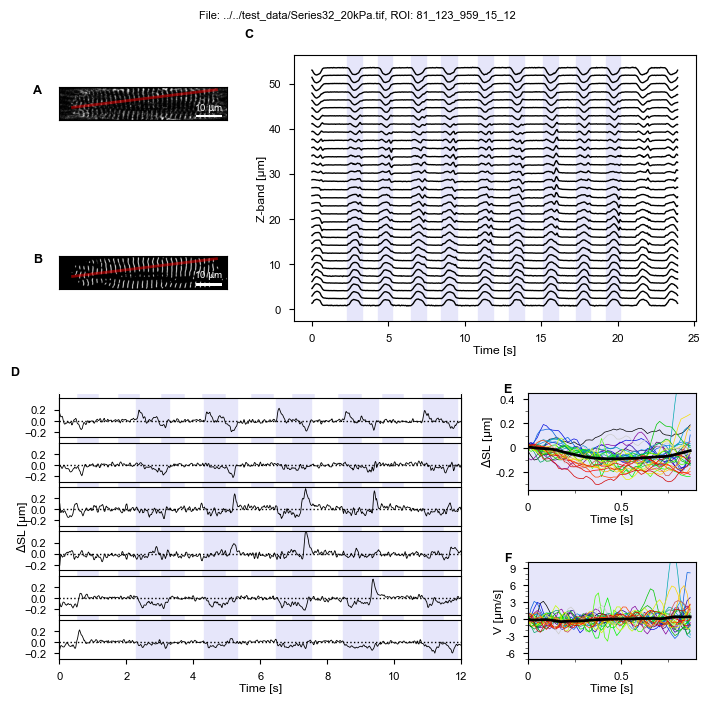

In [8]:
# plot ROI summary
plot_roi_summary_motion(mot_obj)

## Step-by-step analysis for experts

### Detection of Z-band positions

### Tracking of Z-bands 